<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        4560 non-null   object
 1   label       4560 non-null   int64 
 2   label_name  4560 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.0+ KB


,text,label,label_name
0,The Organization of the Petroleum Exporting Co...,0,Business
1,American business tycoon Malcolm Glazer has in...,2,Sports
2,NEW YORK (Reuters) - International Business Ma...,1,SciTech
3,"Unilever, the world #39;s largest maker of foo...",0,Business
4,Australia #39;s Nathan Baggaley was over the m...,2,Sports


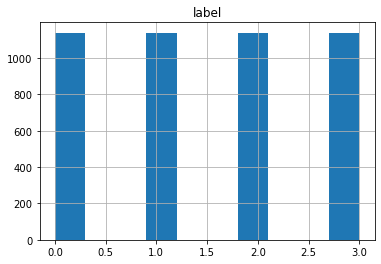

In [1]:
import pandas as pd

df_train = pd.read_json("../data/news_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,While rivals scramble to catch up on the deskt...,1,SciTech
1,AP - UCLA soccer coach Jillian Ellis was happy...,2,Sports
2,PCI Express allows Nvidia to tap into system m...,1,SciTech
3,AP - The Federal Election Commission on Thursd...,3,World
4,City officials hope there are people willing t...,1,SciTech


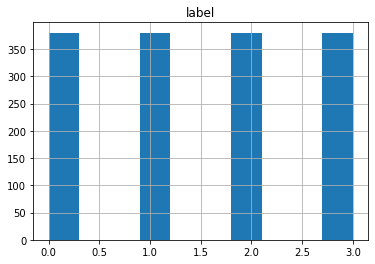

In [2]:
df_test = pd.read_json("../data/news_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,The first hearing in the re-trial of former le...,3,World
1,Intel #39;s board has given the go ahead for t...,0,Business
2,Stocks closed higher on Wall Street as investo...,0,Business
3,Even with a boost from higher oil prices and g...,0,Business
4,Vornado Realty Trust said on Friday it has acq...,0,Business


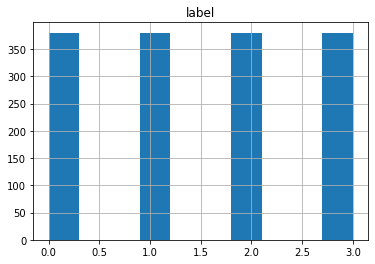

In [3]:
df_val = pd.read_json("../data/news_val.json", orient='records')
df_val.info()
df_val.hist()
df_val.head()

In [4]:
import numpy as np
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt",
                                   lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result, dtype=object)

In [5]:
import tensorflow as tf

maxlen = 128

X_train = list(df_train["text"].values)
X_train = bert_tokenizer(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = df_train["label"].values

X_val = list(df_val["text"].values)
X_val = bert_tokenizer(X_val)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)
y_val = df_val["label"].values


X_test = list(df_test["text"].values)
X_test = bert_tokenizer(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
y_test = df_test["label"].values

In [6]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.SimpleRNN(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model_simple_rnn.compile(optimizer='adam',
                         loss="sparse_categorical_crossentropy",
                         metrics=['accuracy'])

model_simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           976736    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 978,948
Trainable params: 978,948
Non-trainable params: 0
_________________________________________________________________


In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_simple_rnn = model_simple_rnn.fit(X_train, 
                                    y_train,
                                    epochs=5,
                                    batch_size=32,
                                    callbacks=[callback],
                                    validation_data=(X_val, y_val))

Epoch 1/5
143/143 [==============================] - 10s 58ms/step - loss: 1.3691 - accuracy: 0.2983 - val_loss: 1.0939 - val_accuracy: 0.4750
Epoch 2/5
143/143 [==============================] - 7s 46ms/step - loss: 0.8337 - accuracy: 0.6932 - val_loss: 1.0219 - val_accuracy: 0.5414
Epoch 3/5
143/143 [==============================] - 8s 54ms/step - loss: 0.2802 - accuracy: 0.9555 - val_loss: 1.0832 - val_accuracy: 0.5651
Epoch 4/5
143/143 [==============================] - 7s 48ms/step - loss: 0.0606 - accuracy: 0.9968 - val_loss: 1.2411 - val_accuracy: 0.5526
Epoch 5/5
143/143 [==============================] - 8s 53ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 1.3439 - val_accuracy: 0.5500


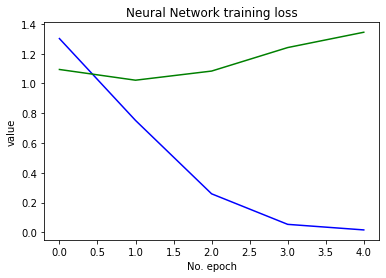

In [8]:
import matplotlib.pyplot as plt

plt.plot(h_simple_rnn.history['loss'], label='(training data)',color='blue')
plt.plot(h_simple_rnn.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

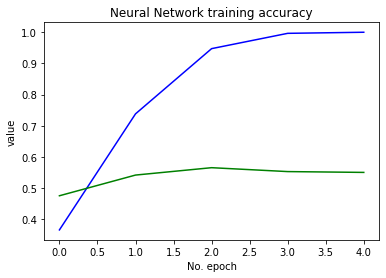

In [9]:
import matplotlib.pyplot as plt

plt.plot(h_simple_rnn.history['accuracy'], label='(training data)',color='blue')
plt.plot(h_simple_rnn.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [10]:
results = model_simple_rnn.evaluate(X_test, y_test, batch_size=32)
print("Simple rnn test loss, test acc:", results)

48/48 [==============================] - 0s 10ms/step - loss: 1.3283 - accuracy: 0.5566
Simple rnn test loss, test acc: [1.3282641172409058, 0.5565789341926575]


In [11]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.LSTM(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model_lstm.compile(optimizer='adam',
                   loss="sparse_categorical_crossentropy",
                   metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           976736    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 985,188
Trainable params: 985,188
Non-trainable params: 0
_________________________________________________________________


In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_lstm = model_lstm.fit(X_train, 
                        y_train,
                        epochs=5,
                        batch_size=32,
                        callbacks=[callback],
                        validation_data=(X_test, y_test))

Epoch 1/5
143/143 [==============================] - 20s 107ms/step - loss: 1.3155 - accuracy: 0.3323 - val_loss: 0.8233 - val_accuracy: 0.6493
Epoch 2/5
143/143 [==============================] - 12s 84ms/step - loss: 0.6315 - accuracy: 0.7325 - val_loss: 0.6153 - val_accuracy: 0.7579
Epoch 3/5
143/143 [==============================] - 11s 80ms/step - loss: 0.3784 - accuracy: 0.8762 - val_loss: 0.5417 - val_accuracy: 0.8013
Epoch 4/5
143/143 [==============================] - 13s 89ms/step - loss: 0.2015 - accuracy: 0.9450 - val_loss: 0.5813 - val_accuracy: 0.8026
Epoch 5/5
143/143 [==============================] - 12s 86ms/step - loss: 0.0886 - accuracy: 0.9802 - val_loss: 0.7236 - val_accuracy: 0.7822


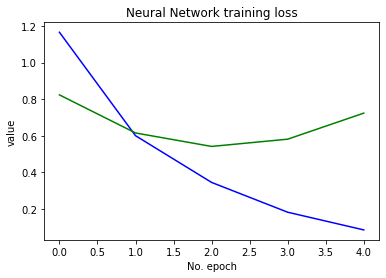

In [13]:
import matplotlib.pyplot as plt

plt.plot(h_lstm.history['loss'], label='(training data)',color='blue')
plt.plot(h_lstm.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

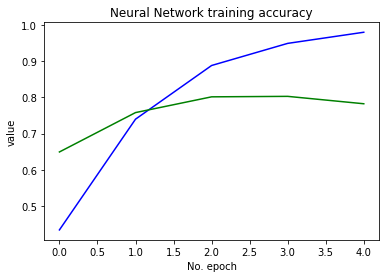

In [14]:
import matplotlib.pyplot as plt

plt.plot(h_lstm.history['accuracy'], label='(training data)',color='blue')
plt.plot(h_lstm.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [15]:
results = model_lstm.evaluate(X_test, y_test, batch_size=32)
print("LSTM test loss, test acc:", results)

48/48 [==============================] - 1s 20ms/step - loss: 0.7236 - accuracy: 0.7822
LSTM test loss, test acc: [0.7236186861991882, 0.7822368144989014]


In [16]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.GRU(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model_gru.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 32)           976736    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 983,204
Trainable params: 983,204
Non-trainable params: 0
_________________________________________________________________


In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_gru = model_gru.fit(X_train, 
                      y_train,
                      epochs=5,
                      batch_size=32,
                      callbacks=[callback],
                      validation_data=(X_test, y_test))

Epoch 1/5
143/143 [==============================] - 19s 96ms/step - loss: 1.3656 - accuracy: 0.2936 - val_loss: 1.0192 - val_accuracy: 0.5033
Epoch 2/5
143/143 [==============================] - 12s 87ms/step - loss: 0.8679 - accuracy: 0.5728 - val_loss: 0.8418 - val_accuracy: 0.6553
Epoch 3/5
143/143 [==============================] - 13s 92ms/step - loss: 0.4429 - accuracy: 0.8769 - val_loss: 0.6774 - val_accuracy: 0.7586
Epoch 4/5
143/143 [==============================] - 13s 91ms/step - loss: 0.1729 - accuracy: 0.9520 - val_loss: 0.7312 - val_accuracy: 0.7651
Epoch 5/5
143/143 [==============================] - 14s 95ms/step - loss: 0.0813 - accuracy: 0.9828 - val_loss: 0.8332 - val_accuracy: 0.7474


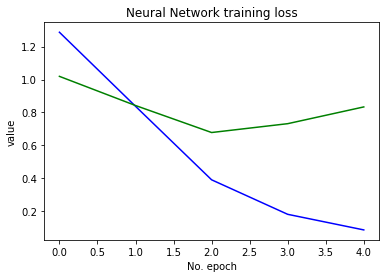

In [18]:
import matplotlib.pyplot as plt

plt.plot(h_gru.history['loss'], label='(training data)',color='blue')
plt.plot(h_gru.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

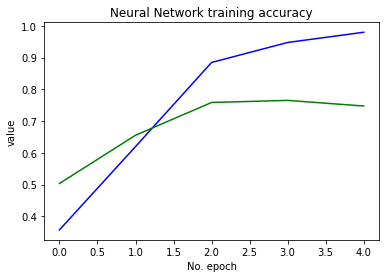

In [19]:
import matplotlib.pyplot as plt

plt.plot(h_gru.history['accuracy'], label='(training data)',color='blue')
plt.plot(h_gru.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [20]:
results = model_gru.evaluate(X_test, y_test, batch_size=32)
print("GRU test loss, test acc:", results)

48/48 [==============================] - 1s 17ms/step - loss: 0.8332 - accuracy: 0.7474
GRU test loss, test acc: [0.8331930637359619, 0.7473683953285217]
